In [2]:
#import sys
#sys.path.append('/home/itsara/env/lib/python2.7/site-packages')

import numpy as np
import pandas as pd
import math
import itertools
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import keras
import matplotlib.pyplot as plt2

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["mv close"] = df.close
df.drop(['volume','close'], 1, inplace=True)
df.head()

,symbol,open,low,high,mv close
date,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,114.970001


In [4]:
symbols = list(set(df.symbol))
symbols[:5]

['AGN', 'EOG', 'CPB', 'EVHC', 'IDXX']

In [5]:
SYM = 'GOOG'
df = df[df.symbol == SYM]
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,mv close
date,,,,
2010-01-04,312.304948,310.955001,313.580158,312.205308
2010-01-05,312.419511,309.610028,312.748278,310.830459
2010-01-06,311.761979,302.048370,311.761979,302.994813
2010-01-07,303.562685,295.218951,303.861575,295.941242
2010-01-08,294.895159,293.455551,300.499172,299.886470


In [6]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
#    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['mv close'] = min_max_scaler.fit_transform(df['mv close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,open,low,high,mv close
date,,,,
2010-01-04,0.157047,0.161167,0.156390,0.159399
2010-01-05,0.157238,0.158884,0.154995,0.157092
2010-01-06,0.156140,0.146049,0.153341,0.143942
2010-01-07,0.142436,0.134457,0.140094,0.132105
2010-01-08,0.127950,0.131464,0.134455,0.138726


In [7]:
def load_data(stock, seq_len):
    n_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]

    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_features))  

    return [x_train, y_train, x_test, y_test]

In [8]:
n_features = 4
prev_days = 5
X_train, y_train, X_test, y_test = load_data(df, prev_days)
print (X_train[0], y_train[0])

(array([[0.15704696, 0.16116746, 0.15638998, 0.15939908],
       [0.15723843, 0.15888449, 0.15499506, 0.15709185],
       [0.15613951, 0.14604929, 0.15334121, 0.14394234],
       [0.14243617, 0.13445699, 0.14009362, 0.13210528],
       [0.12795029, 0.13146379, 0.13445546, 0.13872603]]), 0.1379653023031744)


In [9]:
def build_model(layers):
    p = 0.2
    model = Sequential()

    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(p))

    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(p))

    model.add(Dense(128,activation='relu'))
    model.add(Dense(1,activation='linear'))

    model.compile(loss='mse',optimizer='adam', metrics=['mse'])

    return model

model = build_model([n_features, prev_days, 1])

In [10]:
model.fit(X_train, y_train, batch_size=256, epochs=10, validation_split=0.1, verbose=1)

Train on 1422 samples, validate on 158 samples
Epoch 1/10
1422/1422 [==============================] - 6s 4ms/step - loss: 0.0511 - mean_squared_error: 0.0511 - val_loss: 0.0246 - val_mean_squared_error: 0.02
Epoch 2/10
1422/1422 [==============================] - 2s 1ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0723 - val_mean_squared_error: 0.07
Epoch 3/10
1422/1422 [==============================] - 3s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0081 - val_mean_squared_error: 0.00
Epoch 4/10
1422/1422 [==============================] - 2s 2ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0206 - val_mean_squared_error: 0.02
Epoch 5/10
1422/1422 [==============================] - 2s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0020 - val_mean_squared_error: 0.00
Epoch 6/10
1422/1422 [==============================] - 2s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0031 - val_mean_s

In [11]:
diff=[]
ratio=[]
predict = model.predict(X_test)
for d in range(len(y_test)):
    pred = predict[d][0]
    ratio.append((y_test[d]/pred)-1)
    diff.append(abs(y_test[d]- pred))

In [12]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["mv close"] = df.close
df.drop(['volume', 'close'], 1, inplace=True)
df = df[df.symbol == SYM]
df.drop(['symbol'],1,inplace=True)

def denormalize(df, normalized_value): 
    df = df['mv close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)

    min_max_scaler = preprocessing.MinMaxScaler()
    _ = min_max_scaler.fit_transform(df)
    denorm = min_max_scaler.inverse_transform(normalized_value)
    return denorm

new_pred = denormalize(df, predict)
newy_test = denormalize(df, y_test)

In [13]:
def evaluation(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    print('MSE: %.5f (RMSE: %.2f)' % (score[0], math.sqrt(score[0])))
    return score[0], math.sqrt(score[0])

evaluation(model, X_test, y_test)

MSE: 0.00116 (RMSE: 0.03)


(0.0011562948453832757, 0.03400433568507516)

In [14]:
balance = 100000.0
cash_list= []
volume = 0
buyx = []
buyy =[]
selx = []
sely = []
for i in range(1,len(new_pred)):
    prediction= new_pred[i]
    if(prediction > new_pred[i-1] * 1.002 and volume == 0):
        volume = balance / newy_test[i]
        buyx.append(i)
        buyy.append(newy_test[i])
        print "Buy @" + str(newy_test[i])

    if(volume > 0 and prediction * 1.002 < new_pred[i-1]):
        balance = volume * newy_test[i]
        volume = 0
        selx.append(i)
        sely.append(newy_test[i])
        print "Sell @" + str(newy_test[i])
        print "Balance: " + str(balance)

print "Balance:" + str(balance)
plt2.scatter(buyx, buyy)
plt2.scatter(selx, sely)

Buy @[712.900024]
Sell @[706.630005]
Balance: [99120.49112233]
Buy @[724.119995]
Sell @[728.280029]
Balance: [99689.93350206]
Buy @[694.950012]
Sell @[772.080017]
Balance: [110754.16105324]
Buy @[775.320007]
Sell @[762.48999]
Balance: [108921.39812142]
Buy @[776.219971]
Sell @[772.559998]
Balance: [108407.82028119]
Buy @[796.969971]
Sell @[783.609985]
Balance: [106590.52852121]
Buy @[762.559998]
Sell @[758.48999]
Balance: [106021.6233794]
Buy @[769.200012]
Sell @[762.52002]
Balance: [105100.89588986]
Buy @[789.289978]
Balance:[105100.89588986]


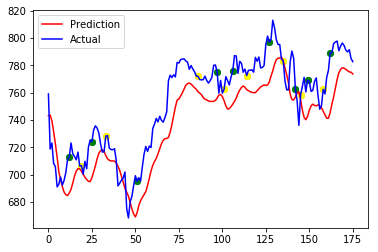

In [15]:
plt2.plot(new_pred,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.scatter(buyx, buyy, color='green')
plt2.scatter(selx, sely, color='yellow')
plt2.show()